In [4]:
"""
"""

from datetime import datetime
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from shapely.geometry import Point, Polygon

from util import get_shapefile_filename, get_shapefile_filepath

%matplotlib inline


# This time around, this is the data of interest:
counties = ['middlesex', 'norfolk', 'suffolk']

# data_filepath = './data/mount/201805/filtered/20180507_20180511/county_middlesex_norfolk_suffolk_3days_3nights.csv'
data_filepath = './data/mount/201805/filtered/20180514_20180518/county_middlesex_norfolk_suffolk_3days_3nights.csv'
# data_filepath = './data/mount/201805/filtered/20180500_20180514/county_middlesex_norfolk_suffolk_7days_6nights.csv'


In [5]:
# Column names defined as variables
COUNTY = 'COUNTY'


# Columns from the census area shapefiles
GEOID = 'GEOID10'

# Columns added
TRACT = 'TRACT'
BLOCKGROUP = 'BLOCKGROUP'
BLOCK = 'BLOCK'


In [6]:
print('reading in data from %s' % data_filepath)
df = pd.read_csv(data_filepath)
print(df.shape)

reading in data from ./data/mount/201805/filtered/20180514_20180518/county_middlesex_norfolk_suffolk_3days_3nights.csv
(518726, 8)


## Attach census tract

reading shapefile ./shapefiles/ma/tract_middlesex_norfolk_suffolk.shp


,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,ALAND10,AWATER10,INTPTLAT10,...,AREA_ACRES,POP100_RE,HU100_RE,LOGPL94171,LOGSF1,LOGACS0610,LOGSF1C,SHAPE_AREA,SHAPE_LEN,geometry
0,25,021,418003,25021418003,4180.03,Census Tract 4180.03,G5020,1705668.0,2936.0,+42.2350240,...,422.1740,2481,1350,0141872,123764,0003690,0123764,1.708484e+06,6274.185034,POLYGON ((-71.00721256587961 42.23014165019458...
1,25,021,417701,25021417701,4177.01,Census Tract 4177.01,G5020,1543651.0,12275.0,+42.2523398,...,384.4502,5417,2983,0141838,123730,0003683,0123730,1.555821e+06,6229.137913,POLYGON ((-71.00345056634727 42.26050865653624...
2,25,021,417702,25021417702,4177.02,Census Tract 4177.02,G5020,1685529.0,317947.0,+42.2582818,...,416.4918,2765,1109,0141843,123735,0003684,0123735,1.685489e+06,8542.498286,POLYGON ((-70.98695456210277 42.26423765714259...


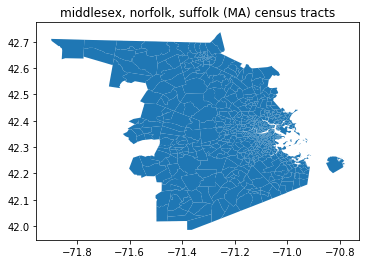

In [7]:
# Load in the shapefile
tracts_shapefile_filepath = get_shapefile_filepath('ma', 'tract', counties)
print('reading shapefile', tracts_shapefile_filepath)

tracts_shapefile = gpd.read_file(tracts_shapefile_filepath).to_crs(epsg=4326)
tracts_shapefile.plot()
plt.title(', '.join(counties) + ' (MA) census tracts')

tracts_shapefile.head(3)

In [8]:

MA_CODE = '25'


def get_geoid_prefix(data_row):
    county_code = str(data_row[COUNTY])
    county_code = ('0' + county_code) if len(county_code) < 3 else county_code
    return MA_CODE + county_code

def get_tract(data_row, shapefile=tracts_shapefile):
    lat = float(data_row['lat'])
    lon = float(data_row['lon'])
    geoid_prefix = get_geoid_prefix(data_row)
    point = Point(lon, lat) # the points actually reverse - yes this looks weird but consider lon the x-axis and lat the y-axis on an x-y plane...
    for i, shp_row in shapefile.iterrows():
        tract_geoid = shp_row[GEOID]
        if not tract_geoid.startswith(geoid_prefix):
            continue
        try:
            # this could be a Polygon or a Multipolygon when the tract contains islands (<3 New England)
            polygon = shp_row['geometry']
            if point.within(polygon):
                return tract_geoid
        except Exception as e:
            print('Exception when looking for point in tract ' + tract_geoid, ': ', e)
            raise e
    print('No tract found for data row!', data_row)
    return None

areas_df = df
areas_df[TRACT] = areas_df.apply(get_tract, axis=1)

No tract found for data row! timestamp                            2018-05-18 22:32:14-04:00
day                                                 2018052000
device ID    c9cc07f8c23c3446ed7cd3d1b3c1b8abdec199e7aed09e...
lat                                                    42.3822
lon                                                    -71.041
GEOID                                                    14460
DwellTime                                              1349.37
COUNTY                                                      25
Name: 31, dtype: object
No tract found for data row! timestamp                            2018-05-18 16:58:38-04:00
day                                                 2018052000
device ID    c1ea30225ef448d63923bae8de7342df0a0728d0d0e4a1...
lat                                                     42.362
lon                                                    -71.035
GEOID                                                    14460
DwellTime                           

No tract found for data row! timestamp                            2018-05-18 09:42:42-04:00
day                                                 2018051800
device ID    48431ebe748a1cde1d12bb83d011a87347f76eb230361f...
lat                                                    42.3621
lon                                                   -71.0297
GEOID                                                    14460
DwellTime                                                    5
COUNTY                                                      25
Name: 9282, dtype: object
No tract found for data row! timestamp                            2018-05-18 14:48:33-04:00
day                                                 2018051800
device ID    efba79b347e7e77ee7d28c5840c81ce270107a0d9ef12e...
lat                                                    42.3619
lon                                                   -71.0486
GEOID                                                    14460
DwellTime                         

No tract found for data row! timestamp                            2018-05-17 18:48:37-04:00
day                                                 2018051800
device ID    9a19288d2b779178a08145981ca6eadf640854cd359ca7...
lat                                                    42.3588
lon                                                   -71.0501
GEOID                                                    14460
DwellTime                                                76.72
COUNTY                                                      25
Name: 18987, dtype: object
No tract found for data row! timestamp                            2018-05-17 22:10:27-04:00
day                                                 2018051800
device ID    c1ea30225ef448d63923bae8de7342df0a0728d0d0e4a1...
lat                                                    42.3618
lon                                                   -71.0351
GEOID                                                    14460
DwellTime                        

No tract found for data row! timestamp                            2018-05-17 18:04:34-04:00
day                                                 2018051800
device ID    71a01842a62cb83d2023e7e685e003582b28387df0f1db...
lat                                                    42.3708
lon                                                   -71.0591
GEOID                                                    14460
DwellTime                                                 1360
COUNTY                                                      25
Name: 28289, dtype: object
No tract found for data row! timestamp                            2018-05-18 16:32:47-04:00
day                                                 2018051800
device ID    ef36a1e2f28cf389750b2c72a29a68fa29cc64b047f10d...
lat                                                    42.3619
lon                                                   -71.0351
GEOID                                                    14460
DwellTime                        

No tract found for data row! timestamp                            2018-05-17 21:52:44-04:00
day                                                 2018051800
device ID    11a08d0895fe4195c3f652d786d5c73447f012928b46c3...
lat                                                    42.3609
lon                                                   -71.0485
GEOID                                                    14460
DwellTime                                                25.13
COUNTY                                                      25
Name: 33743, dtype: object
No tract found for data row! timestamp                            2018-05-18 10:51:20-04:00
day                                                 2018051800
device ID    8996bf22be4181486e4f04cd3eea4769fa9d0958150078...
lat                                                    42.3725
lon                                                   -71.0566
GEOID                                                    14460
DwellTime                        

No tract found for data row! timestamp                            2018-05-18 17:44:00-04:00
day                                                 2018051800
device ID    e5d162c62c9307415797fef5307b00da20ecc757e10836...
lat                                                     42.375
lon                                                    -71.049
GEOID                                                    14460
DwellTime                                                11.52
COUNTY                                                      25
Name: 45912, dtype: object
No tract found for data row! timestamp                            2018-05-18 08:39:09-04:00
day                                                 2018051800
device ID    6507ce832a1f2a766391a4cfc915f39eb2cf1c6deba9ec...
lat                                                     42.349
lon                                                   -71.0375
GEOID                                                    14460
DwellTime                        

No tract found for data row! timestamp                            2018-05-18 15:13:56-04:00
day                                                 2018051800
device ID    71387c1abeaa353a388687bed978b4377d174b9569a5bd...
lat                                                    42.3626
lon                                                   -71.0507
GEOID                                                    14460
DwellTime                                                61.75
COUNTY                                                      25
Name: 51398, dtype: object
No tract found for data row! timestamp                            2018-05-18 15:29:28-04:00
day                                                 2018051800
device ID    efba79b347e7e77ee7d28c5840c81ce270107a0d9ef12e...
lat                                                    42.3619
lon                                                   -71.0484
GEOID                                                    14460
DwellTime                        

No tract found for data row! timestamp                            2018-05-18 17:51:55-04:00
day                                                 2018051800
device ID    ea0585449db27a785bf7406f8a6ee0b4d7fc92c3210590...
lat                                                     42.361
lon                                                   -71.0501
GEOID                                                    14460
DwellTime                                                 2.32
COUNTY                                                      25
Name: 57004, dtype: object
No tract found for data row! timestamp                            2018-05-18 09:52:38-04:00
day                                                 2018051800
device ID    bfa5f9b7b674bf3dc0a3e7f5b6d7d5a6131801830061d1...
lat                                                    42.3216
lon                                                   -70.9888
GEOID                                                    14460
DwellTime                        

No tract found for data row! timestamp                            2018-05-18 01:36:41-04:00
day                                                 2018051800
device ID    f5e82e1d8502326b7a88803002f6922024b3cd26ddb3ee...
lat                                                    42.3756
lon                                                    -71.049
GEOID                                                    14460
DwellTime                                                56.18
COUNTY                                                      25
Name: 61771, dtype: object
No tract found for data row! timestamp                            2018-05-18 14:43:06-04:00
day                                                 2018051800
device ID    afc90b906ccf74719fab640d57c777e9e40af0ded058e4...
lat                                                    42.3752
lon                                                   -71.0486
GEOID                                                    14460
DwellTime                        

No tract found for data row! timestamp                            2018-05-18 08:19:27-04:00
day                                                 2018051800
device ID    5f9d1cdff67cb6c599fc774a59bc015f996bf053e10e52...
lat                                                    42.3736
lon                                                   -71.0508
GEOID                                                    14460
DwellTime                                                  3.3
COUNTY                                                      25
Name: 68913, dtype: object
No tract found for data row! timestamp                            2018-05-17 20:00:42-04:00
day                                                 2018051800
device ID    a88d50fbf16f49a0c796a067a1826fdc84283a2a306eb3...
lat                                                    42.3604
lon                                                   -71.0748
GEOID                                                    14460
DwellTime                        

No tract found for data row! timestamp                            2018-05-17 21:17:14-04:00
day                                                 2018051800
device ID    37f43e0301f938676c7bb8c6c52bd3bbd16c8e13797c45...
lat                                                    42.3552
lon                                                   -71.0958
GEOID                                                    14460
DwellTime                                                 4.33
COUNTY                                                      17
Name: 77259, dtype: object
No tract found for data row! timestamp                            2018-05-18 07:27:17-04:00
day                                                 2018051800
device ID    3ca2175b263812f08c4fc272216c6db22437dd69b8b1a0...
lat                                                    42.3527
lon                                                   -71.0413
GEOID                                                    14460
DwellTime                        

No tract found for data row! timestamp                            2018-05-18 12:22:42-04:00
day                                                 2018051800
device ID    28643fe4531831bcaaa0fb737f38903b9111a7ad44bffc...
lat                                                     42.371
lon                                                   -71.0542
GEOID                                                    14460
DwellTime                                                 3.18
COUNTY                                                      25
Name: 84086, dtype: object
No tract found for data row! timestamp                            2018-05-18 08:47:56-04:00
day                                                 2018051800
device ID    bc38bd153ed979a95c4214d3b3f8c1a1e9e1ebd7f3e880...
lat                                                    42.3566
lon                                                   -71.0497
GEOID                                                    14460
DwellTime                        

No tract found for data row! timestamp                            2018-05-17 06:00:27-04:00
day                                                 2018051800
device ID    6677f3efaba530ac24c985690e1d48e2ac38ef1b1bc4ab...
lat                                                    42.3694
lon                                                   -71.0517
GEOID                                                    14460
DwellTime                                              1959.25
COUNTY                                                      25
Name: 91587, dtype: object
No tract found for data row! timestamp                            2018-05-18 13:52:46-04:00
day                                                 2018051800
device ID    bfa5f9b7b674bf3dc0a3e7f5b6d7d5a6131801830061d1...
lat                                                    42.3216
lon                                                   -70.9886
GEOID                                                    14460
DwellTime                        

No tract found for data row! timestamp                            2018-05-18 05:55:16-04:00
day                                                 2018051800
device ID    8d2277260f8ae8a000ebb29272d0b0f3c4c5f79a074deb...
lat                                                    42.3753
lon                                                   -71.0501
GEOID                                                    14460
DwellTime                                                18.55
COUNTY                                                      25
Name: 99358, dtype: object
No tract found for data row! timestamp                            2018-05-18 08:56:22-04:00
day                                                 2018051800
device ID    c047a6cfac96300bf3a0c9d01dddd1b2d4c4dc46c39fc7...
lat                                                    42.2589
lon                                                   -70.9258
GEOID                                                    14460
DwellTime                        

No tract found for data row! timestamp                            2018-05-18 21:35:45-04:00
day                                                 2018051900
device ID    70fffebc5fdb517f4a428b1f23d34a945d89b172c82b4f...
lat                                                    42.3705
lon                                                   -71.0599
GEOID                                                    14460
DwellTime                                                 89.9
COUNTY                                                      25
Name: 106241, dtype: object
No tract found for data row! timestamp                            2018-05-18 20:12:21-04:00
day                                                 2018051900
device ID    95d2ee9934a7169d5cc6985f96cd948e3e8aee95d35270...
lat                                                    42.2422
lon                                                   -70.9708
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-18 20:41:18-04:00
day                                                 2018051900
device ID    e5d162c62c9307415797fef5307b00da20ecc757e10836...
lat                                                     42.375
lon                                                    -71.049
GEOID                                                    14460
DwellTime                                                 21.9
COUNTY                                                      25
Name: 118996, dtype: object
No tract found for data row! timestamp                            2018-05-18 21:14:34-04:00
day                                                 2018051900
device ID    725ce9f500895f126ffe645fbbcf394e9a313cc57e0ac1...
lat                                                    42.3607
lon                                                   -71.1165
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-18 19:58:57-04:00
day                                                 2018051900
device ID    e5db5fe8bee859dba76276703bdbb0d9bfa1cad8402194...
lat                                                    42.3584
lon                                                   -71.0474
GEOID                                                    14460
DwellTime                                                89.88
COUNTY                                                      25
Name: 124694, dtype: object
No tract found for data row! timestamp                            2018-05-18 19:31:38-04:00
day                                                 2018051900
device ID    a1ba77273cb872016f847e8f69ea9cf99bfb9608c1ae87...
lat                                                    42.3963
lon                                                   -71.0782
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-15 12:40:23-04:00
day                                                 2018051500
device ID    7ddf62f14f96242da4202c85a37827538f6119f7f5d182...
lat                                                    42.3526
lon                                                   -71.0522
GEOID                                                    14460
DwellTime                                                30.77
COUNTY                                                      25
Name: 144023, dtype: object
No tract found for data row! timestamp                            2018-05-15 18:30:42-04:00
day                                                 2018051500
device ID    9acf62c1e90795d9c07c8c53bb28d6f01c090589a4dd9e...
lat                                                    42.3526
lon                                                   -71.0519
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-15 18:50:47-04:00
day                                                 2018051500
device ID    048dbc7ced44b06839c3c81abba929dfe8ff4b32098d79...
lat                                                     42.347
lon                                                   -71.0287
GEOID                                                    14460
DwellTime                                                 2.07
COUNTY                                                      25
Name: 149067, dtype: object
No tract found for data row! timestamp                            2018-05-15 06:25:40-04:00
day                                                 2018051500
device ID    ca988ab5b50fcd304f9275b4ed34645912cfead0ee5cc7...
lat                                                    42.3595
lon                                                   -71.0505
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-14 18:43:08-04:00
day                                                 2018051500
device ID    24cb8ffcee82aa001dc617a6542c8fd0bf5ba0c4c0b130...
lat                                                    42.3726
lon                                                   -71.0523
GEOID                                                    14460
DwellTime                                                 2.47
COUNTY                                                      25
Name: 155451, dtype: object
No tract found for data row! timestamp                            2018-05-15 14:37:06-04:00
day                                                 2018051500
device ID    9313203d666a44c6e9e2ea1d4ee88bae7d3853b2d544a1...
lat                                                    42.3567
lon                                                   -71.0495
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-14 17:10:02-04:00
day                                                 2018051500
device ID    1f7a90c6e17839e418aaa28deb72e6db073c4e801e3874...
lat                                                    42.3528
lon                                                   -71.0515
GEOID                                                    14460
DwellTime                                                 7.35
COUNTY                                                      25
Name: 164644, dtype: object
No tract found for data row! timestamp                            2018-05-15 14:52:28-04:00
day                                                 2018051500
device ID    24cb8ffcee82aa001dc617a6542c8fd0bf5ba0c4c0b130...
lat                                                    42.3619
lon                                                   -71.0484
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-15 16:34:33-04:00
day                                                 2018051500
device ID    a05b000c4cf05a03d6066a9dd290060208cee0bd0d08ec...
lat                                                    42.3553
lon                                                   -71.0414
GEOID                                                    14460
DwellTime                                                 6.27
COUNTY                                                      25
Name: 174642, dtype: object
No tract found for data row! timestamp                            2018-05-15 15:29:34-04:00
day                                                 2018051500
device ID    4168743f6bcb813eb843c2cd5f9f78195230bbc11e1299...
lat                                                    42.3488
lon                                                   -71.0376
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-14 17:39:37-04:00
day                                                 2018051500
device ID    9f17389f50031f8c9c23167c9a14101f4141c56b036b97...
lat                                                     42.363
lon                                                   -71.0508
GEOID                                                    14460
DwellTime                                                12.32
COUNTY                                                      25
Name: 180485, dtype: object
No tract found for data row! timestamp                            2018-05-14 19:52:01-04:00
day                                                 2018051500
device ID    71a01842a62cb83d2023e7e685e003582b28387df0f1db...
lat                                                    42.3707
lon                                                   -71.0577
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-15 17:25:59-04:00
day                                                 2018051500
device ID    968a729bfd4b3e45b322911fe9a690d062125b19b87fb6...
lat                                                    42.3685
lon                                                   -70.9719
GEOID                                                    14460
DwellTime                                               121.25
COUNTY                                                      25
Name: 185128, dtype: object
No tract found for data row! timestamp                            2018-05-14 06:15:43-04:00
day                                                 2018051500
device ID    422891e120994197c29e0267ca3001f99a4166b7e86dd7...
lat                                                     42.347
lon                                                   -71.0287
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-14 23:24:17-04:00
day                                                 2018051500
device ID    eab0f487ce061e0d11f91af5d7a4eaa26fbb757f63a0e7...
lat                                                    42.3453
lon                                                   -71.0154
GEOID                                                    14460
DwellTime                                                 2.67
COUNTY                                                      25
Name: 192252, dtype: object
No tract found for data row! timestamp                            2018-05-15 19:03:01-04:00
day                                                 2018051500
device ID    9acf62c1e90795d9c07c8c53bb28d6f01c090589a4dd9e...
lat                                                    42.3527
lon                                                   -71.0521
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-15 09:29:37-04:00
day                                                 2018051500
device ID    2ece6d7fb6fffc690148c78838056f4ad053d5b962de75...
lat                                                    42.3817
lon                                                    -71.049
GEOID                                                    14460
DwellTime                                                20.85
COUNTY                                                      25
Name: 198253, dtype: object
No tract found for data row! timestamp                            2018-05-15 18:38:38-04:00
day                                                 2018051500
device ID    8d2277260f8ae8a000ebb29272d0b0f3c4c5f79a074deb...
lat                                                    42.3745
lon                                                   -71.0488
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-15 15:39:05-04:00
day                                                 2018051500
device ID    24cb8ffcee82aa001dc617a6542c8fd0bf5ba0c4c0b130...
lat                                                    42.3701
lon                                                   -71.0509
GEOID                                                    14460
DwellTime                                                 2.53
COUNTY                                                      25
Name: 204671, dtype: object
No tract found for data row! timestamp                            2018-05-15 19:56:09-04:00
day                                                 2018051500
device ID    57f97e46d12ae138cf21aceabd54963a4998331563cf5f...
lat                                                    42.3709
lon                                                    -71.057
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-14 18:54:19-04:00
day                                                 2018051500
device ID    b1ffbc531456f90ff0cfc610d13beb4a77d047a33d08dc...
lat                                                     42.354
lon                                                   -71.0999
GEOID                                                    14460
DwellTime                                                  5.7
COUNTY                                                      17
Name: 210524, dtype: object
No tract found for data row! timestamp                            2018-05-15 10:01:07-04:00
day                                                 2018051500
device ID    d08260d0245139a2460cf05666dd6f5554353b5ad7d02e...
lat                                                    42.3496
lon                                                   -71.0316
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-15 13:05:00-04:00
day                                                 2018051500
device ID    aa71ff76a05e8ef5170e8c9600fa624e2b01d4550a2b3d...
lat                                                    42.4068
lon                                                   -70.9909
GEOID                                                    14460
DwellTime                                                 2.17
COUNTY                                                      25
Name: 216635, dtype: object
No tract found for data row! timestamp                            2018-05-15 09:56:57-04:00
day                                                 2018051500
device ID    2ece6d7fb6fffc690148c78838056f4ad053d5b962de75...
lat                                                    42.3816
lon                                                   -71.0489
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-15 14:07:56-04:00
day                                                 2018051500
device ID    24cb8ffcee82aa001dc617a6542c8fd0bf5ba0c4c0b130...
lat                                                    42.3702
lon                                                    -71.047
GEOID                                                    14460
DwellTime                                                 3.48
COUNTY                                                      25
Name: 221544, dtype: object
No tract found for data row! timestamp                            2018-05-14 18:33:30-04:00
day                                                 2018051500
device ID    4e6a36e6b7fd1b3d0220bd05c7f822134bc420cc42a152...
lat                                                    42.3727
lon                                                   -71.0525
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-14 20:29:09-04:00
day                                                 2018051500
device ID    ea0585449db27a785bf7406f8a6ee0b4d7fc92c3210590...
lat                                                    42.3608
lon                                                   -71.0502
GEOID                                                    14460
DwellTime                                                 2.43
COUNTY                                                      25
Name: 231053, dtype: object
No tract found for data row! timestamp                            2018-05-14 17:15:04-04:00
day                                                 2018051500
device ID    28afdddb7cdfb0712fd82915b74061f20daa403efc1a60...
lat                                                    42.3356
lon                                                   -71.0231
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-15 13:53:31-04:00
day                                                 2018051500
device ID    f9e71e1fc231ba2d1faeb65c7c4a6219e071f39b592a53...
lat                                                     42.404
lon                                                   -71.0725
GEOID                                                    14460
DwellTime                                                  2.8
COUNTY                                                      17
Name: 238755, dtype: object
No tract found for data row! timestamp                            2018-05-16 13:58:58-04:00
day                                                 2018051600
device ID    8e64e0c6d832e5b78b096d043d5fa0fb356366dc1b5480...
lat                                                    42.3812
lon                                                   -70.9923
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-16 10:43:15-04:00
day                                                 2018051600
device ID    58c1519dd618cc7b31fa6481672f28520a3d5ff48a9e47...
lat                                                    42.3706
lon                                                   -71.0591
GEOID                                                    14460
DwellTime                                                97.85
COUNTY                                                      25
Name: 247279, dtype: object
No tract found for data row! timestamp                            2018-05-16 12:45:54-04:00
day                                                 2018051600
device ID    6f6e6786613fd7a332fb2037f451d24d11aa43e5f5c836...
lat                                                    42.3506
lon                                                   -71.0514
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-16 17:35:48-04:00
day                                                 2018051600
device ID    b13b0ef86d6ca489769a3aba36ed91beea45bc0530cd09...
lat                                                    42.3608
lon                                                   -71.0493
GEOID                                                    14460
DwellTime                                                 8.68
COUNTY                                                      25
Name: 253339, dtype: object
No tract found for data row! timestamp                            2018-05-16 15:06:00-04:00
day                                                 2018051600
device ID    361fc0d9025903d7c66bdda30798eff33aa5985fc11c59...
lat                                                     42.349
lon                                                   -71.0308
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-16 16:56:23-04:00
day                                                 2018051600
device ID    e61f335d83d672ee603c841c90938e94a86ab986ba52f1...
lat                                                    42.3673
lon                                                   -71.0602
GEOID                                                    14460
DwellTime                                                  6.1
COUNTY                                                      25
Name: 261838, dtype: object
No tract found for data row! timestamp                            2018-05-15 22:59:35-04:00
day                                                 2018051600
device ID    9acf62c1e90795d9c07c8c53bb28d6f01c090589a4dd9e...
lat                                                    42.3525
lon                                                   -71.0518
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-15 19:38:11-04:00
day                                                 2018051600
device ID    24cb8ffcee82aa001dc617a6542c8fd0bf5ba0c4c0b130...
lat                                                     42.372
lon                                                   -71.0571
GEOID                                                    14460
DwellTime                                                 3.45
COUNTY                                                      25
Name: 271102, dtype: object
No tract found for data row! timestamp                            2018-05-16 08:15:45-04:00
day                                                 2018051600
device ID    3ca2175b263812f08c4fc272216c6db22437dd69b8b1a0...
lat                                                    42.3933
lon                                                    -71.071
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-15 18:45:08-04:00
day                                                 2018051600
device ID    88b702783e2c4cf2fc86fa0793753e4ea3c1f628723f83...
lat                                                    42.2796
lon                                                   -71.0139
GEOID                                                    14460
DwellTime                                                74.68
COUNTY                                                      21
Name: 279098, dtype: object
No tract found for data row! timestamp                            2018-05-16 09:31:25-04:00
day                                                 2018051600
device ID    f9e71e1fc231ba2d1faeb65c7c4a6219e071f39b592a53...
lat                                                    42.3891
lon                                                   -71.0685
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-16 09:30:11-04:00
day                                                 2018051600
device ID    bfa5f9b7b674bf3dc0a3e7f5b6d7d5a6131801830061d1...
lat                                                     42.371
lon                                                   -70.9744
GEOID                                                    14460
DwellTime                                               445.17
COUNTY                                                      25
Name: 288303, dtype: object
No tract found for data row! timestamp                            2018-05-16 16:00:27-04:00
day                                                 2018051600
device ID    ea0585449db27a785bf7406f8a6ee0b4d7fc92c3210590...
lat                                                    42.3526
lon                                                   -71.0507
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-16 12:45:30-04:00
day                                                 2018051600
device ID    f75e10bd4b9380ddbf1ebb750f46cb97864d7f4641185f...
lat                                                    42.3802
lon                                                   -71.0502
GEOID                                                    14460
DwellTime                                                 7.17
COUNTY                                                      25
Name: 296204, dtype: object
No tract found for data row! timestamp                            2018-05-16 15:28:06-04:00
day                                                 2018051600
device ID    ea0585449db27a785bf7406f8a6ee0b4d7fc92c3210590...
lat                                                    42.3525
lon                                                   -71.0514
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-16 17:53:37-04:00
day                                                 2018051600
device ID    8d2277260f8ae8a000ebb29272d0b0f3c4c5f79a074deb...
lat                                                    42.3745
lon                                                   -71.0489
GEOID                                                    14460
DwellTime                                               112.37
COUNTY                                                      25
Name: 305371, dtype: object
No tract found for data row! timestamp                            2018-05-16 15:46:46-04:00
day                                                 2018051600
device ID    18a235649ba8d3c0e149bd80be72e0f9eb1f4a04839d44...
lat                                                    42.3561
lon                                                   -71.0496
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-16 07:18:37-04:00
day                                                 2018051600
device ID    422891e120994197c29e0267ca3001f99a4166b7e86dd7...
lat                                                    42.3471
lon                                                   -71.0288
GEOID                                                    14460
DwellTime                                                 15.8
COUNTY                                                      25
Name: 317152, dtype: object
No tract found for data row! timestamp                            2018-05-16 18:04:41-04:00
day                                                 2018051600
device ID    8882df8ff3773d7cf6c3b1f5cdfbe2b32eeafc2a614bf4...
lat                                                     42.356
lon                                                    -71.044
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-16 06:13:14-04:00
day                                                 2018051600
device ID    422891e120994197c29e0267ca3001f99a4166b7e86dd7...
lat                                                     42.347
lon                                                   -71.0288
GEOID                                                    14460
DwellTime                                                 56.8
COUNTY                                                      25
Name: 323837, dtype: object
No tract found for data row! timestamp                            2018-05-16 14:53:10-04:00
day                                                 2018051600
device ID    7284d71ae8bbfcb6658b503a47fe7a8f82580b0b4a7012...
lat                                                    42.4012
lon                                                   -71.0888
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-16 11:52:59-04:00
day                                                 2018051600
device ID    5f9d1cdff67cb6c599fc774a59bc015f996bf053e10e52...
lat                                                    42.3729
lon                                                     -71.05
GEOID                                                    14460
DwellTime                                                 4.48
COUNTY                                                      25
Name: 328956, dtype: object
No tract found for data row! timestamp                            2018-05-15 22:31:04-04:00
day                                                 2018051600
device ID    4bbebfd499b237ce3dd3478adebf153b0d0c7c1b86a3d7...
lat                                                    42.3511
lon                                                   -71.0423
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-16 19:22:09-04:00
day                                                 2018051600
device ID    70fffebc5fdb517f4a428b1f23d34a945d89b172c82b4f...
lat                                                    42.3705
lon                                                   -71.0594
GEOID                                                    14460
DwellTime                                                 3.48
COUNTY                                                      25
Name: 335838, dtype: object
No tract found for data row! timestamp                            2018-05-16 19:13:56-04:00
day                                                 2018051600
device ID    dc4fa3a7462f5995ae2f66ac3c689646f7c7b97edd5863...
lat                                                    42.3523
lon                                                   -71.0409
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-15 20:25:35-04:00
day                                                 2018051600
device ID    c40ffaa8f0d1f4f865485f7e3d8c87d2c4916767a2750c...
lat                                                    42.3518
lon                                                   -71.0414
GEOID                                                    14460
DwellTime                                                13.37
COUNTY                                                      25
Name: 343292, dtype: object
No tract found for data row! timestamp                            2018-05-16 06:46:05-04:00
day                                                 2018051600
device ID    3f2177afb263d3450f6eac65cc9ea6cd824e6a481d665b...
lat                                                    42.3614
lon                                                   -71.0734
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-16 20:32:20-04:00
day                                                 2018051700
device ID    5014b3864bf0597b5c2924b6eac783bd11e071e1216782...
lat                                                    42.2995
lon                                                    -71.029
GEOID                                                    14460
DwellTime                                                54.73
COUNTY                                                      21
Name: 349628, dtype: object
No tract found for data row! timestamp                            2018-05-17 16:12:47-04:00
day                                                 2018051700
device ID    11a08d0895fe4195c3f652d786d5c73447f012928b46c3...
lat                                                    42.3591
lon                                                   -71.0788
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-17 10:55:47-04:00
day                                                 2018051700
device ID    5dd453c5a9ae9aa95d0857a92eb8aa497a59d132ea5acf...
lat                                                    42.3938
lon                                                   -71.0501
GEOID                                                    14460
DwellTime                                                37.87
COUNTY                                                      25
Name: 356430, dtype: object
No tract found for data row! timestamp                            2018-05-17 16:17:15-04:00
day                                                 2018051700
device ID    11a08d0895fe4195c3f652d786d5c73447f012928b46c3...
lat                                                    42.3579
lon                                                   -71.0779
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-17 13:33:52-04:00
day                                                 2018051700
device ID    6134a2fa75144b62fc07efe002fbc96825cc387f79aa2c...
lat                                                    42.3518
lon                                                   -71.0504
GEOID                                                    14460
DwellTime                                                15.45
COUNTY                                                      25
Name: 361934, dtype: object
No tract found for data row! timestamp                            2018-05-17 10:21:04-04:00
day                                                 2018051700
device ID    899c4213d0ab6dbfd4f74e066c5190ac7ce508cc6a128c...
lat                                                     42.369
lon                                                   -71.0527
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-16 22:12:49-04:00
day                                                 2018051700
device ID    e6583d71b4939098235b2cadea943c4fd4986848adc0eb...
lat                                                    42.3505
lon                                                   -71.0513
GEOID                                                    14460
DwellTime                                                24.32
COUNTY                                                      25
Name: 368568, dtype: object
No tract found for data row! timestamp                            2018-05-17 15:57:34-04:00
day                                                 2018051700
device ID    11a08d0895fe4195c3f652d786d5c73447f012928b46c3...
lat                                                    42.3609
lon                                                   -71.0739
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-17 05:01:35-04:00
day                                                 2018051700
device ID    f72120ddaa60ef75644cb032a5c4160b094fe2ccf1485c...
lat                                                    42.3581
lon                                                   -71.0282
GEOID                                                    14460
DwellTime                                                 2.03
COUNTY                                                      25
Name: 375201, dtype: object
No tract found for data row! timestamp                            2018-05-17 04:42:32-04:00
day                                                 2018051700
device ID    e5d162c62c9307415797fef5307b00da20ecc757e10836...
lat                                                    42.3751
lon                                                   -71.0485
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-17 10:16:46-04:00
day                                                 2018051700
device ID    d288a4ef679ed1d55e5b7996b3321379e4c7f75493038f...
lat                                                    42.3195
lon                                                    -70.931
GEOID                                                    14460
DwellTime                                                 4.22
COUNTY                                                      25
Name: 379896, dtype: object
No tract found for data row! timestamp                            2018-05-16 19:43:16-04:00
day                                                 2018051700
device ID    78a96a9e4b1881fbe38a766109ff78085db29295b06f0a...
lat                                                    42.3623
lon                                                   -71.0265
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-16 20:16:13-04:00
day                                                 2018051700
device ID    97f3d84dc5fb019803c805d3ba0b2161dc20755dd5041b...
lat                                                    42.3505
lon                                                   -71.0515
GEOID                                                    14460
DwellTime                                                39.28
COUNTY                                                      25
Name: 385506, dtype: object
No tract found for data row! timestamp                            2018-05-16 05:28:18-04:00
day                                                 2018051700
device ID    b485831dc638fa918075bc29a0beaa478d543fd15a524e...
lat                                                    42.3486
lon                                                    -71.031
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-17 06:52:50-04:00
day                                                 2018051700
device ID    bfa5f9b7b674bf3dc0a3e7f5b6d7d5a6131801830061d1...
lat                                                    42.3709
lon                                                   -70.9743
GEOID                                                    14460
DwellTime                                                248.6
COUNTY                                                      25
Name: 392501, dtype: object
No tract found for data row! timestamp                            2018-05-17 15:04:43-04:00
day                                                 2018051700
device ID    f7a74dfe17d94c0b07738f8e54e2a14820601372ebca5e...
lat                                                    42.3519
lon                                                   -71.0385
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-17 10:58:16-04:00
day                                                 2018051700
device ID    6f6e6786613fd7a332fb2037f451d24d11aa43e5f5c836...
lat                                                    42.3495
lon                                                   -71.0532
GEOID                                                    14460
DwellTime                                                 2.18
COUNTY                                                      25
Name: 400829, dtype: object
No tract found for data row! timestamp                            2018-05-16 19:10:27-04:00
day                                                 2018051700
device ID    3eae547a94adc99c96e77368872e783d90580353d7dd8f...
lat                                                     42.354
lon                                                   -71.0399
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-17 06:42:46-04:00
day                                                 2018051700
device ID    319cb349f4e758b3c7efba317c28c613abf2e576508dfc...
lat                                                     42.347
lon                                                   -71.0287
GEOID                                                    14460
DwellTime                                                49.12
COUNTY                                                      25
Name: 407862, dtype: object
No tract found for data row! timestamp                            2018-05-17 08:47:47-04:00
day                                                 2018051700
device ID    e1865cbeeebf5278ace933044ec4d95da5a6016bb5f96d...
lat                                                    42.3617
lon                                                   -71.0357
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-17 12:33:14-04:00
day                                                 2018051700
device ID    e1fd03353446e16875d72aa5ef1c1b75f61c433d1ff419...
lat                                                    42.3709
lon                                                   -71.0571
GEOID                                                    14460
DwellTime                                                 2.82
COUNTY                                                      25
Name: 410990, dtype: object
No tract found for data row! timestamp                            2018-05-16 22:56:04-04:00
day                                                 2018051700
device ID    70fffebc5fdb517f4a428b1f23d34a945d89b172c82b4f...
lat                                                     42.397
lon                                                   -71.0791
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-17 19:23:29-04:00
day                                                 2018051700
device ID    845f901754cc1408100ff06ca7836e7369da1d0ab6905a...
lat                                                    42.2995
lon                                                   -71.0441
GEOID                                                    14460
DwellTime                                                 5.13
COUNTY                                                      25
Name: 417190, dtype: object
No tract found for data row! timestamp                            2018-05-17 08:59:59-04:00
day                                                 2018051700
device ID    b13b0ef86d6ca489769a3aba36ed91beea45bc0530cd09...
lat                                                    42.3624
lon                                                   -71.0342
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-16 21:13:46-04:00
day                                                 2018051700
device ID    3eae547a94adc99c96e77368872e783d90580353d7dd8f...
lat                                                     42.354
lon                                                   -71.0399
GEOID                                                    14460
DwellTime                                                 2.03
COUNTY                                                      25
Name: 422616, dtype: object
No tract found for data row! timestamp                            2018-05-17 15:17:16-04:00
day                                                 2018051700
device ID    a1ba77273cb872016f847e8f69ea9cf99bfb9608c1ae87...
lat                                                    42.3964
lon                                                   -71.0782
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-17 14:03:00-04:00
day                                                 2018051700
device ID    6134a2fa75144b62fc07efe002fbc96825cc387f79aa2c...
lat                                                    42.3523
lon                                                   -71.0512
GEOID                                                    14460
DwellTime                                                63.07
COUNTY                                                      25
Name: 427167, dtype: object
No tract found for data row! timestamp                            2018-05-17 16:58:59-04:00
day                                                 2018051700
device ID    45166e1707d49c1cd9f47c1671c0aca7c730d36fc36759...
lat                                                     42.406
lon                                                   -70.9897
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-17 06:31:36-04:00
day                                                 2018051700
device ID    a5c61963370f0b384679695c311355226bb12b87b3baf5...
lat                                                    42.3491
lon                                                   -71.0315
GEOID                                                    14460
DwellTime                                               272.73
COUNTY                                                      25
Name: 433964, dtype: object
No tract found for data row! timestamp                            2018-05-17 19:14:35-04:00
day                                                 2018051700
device ID    dacf6eed2c460908023f6ea988a94b3d60cf87f460c2c5...
lat                                                    42.3521
lon                                                   -71.0516
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-17 19:13:47-04:00
day                                                 2018051700
device ID    97719f9d7da773e4566e85a04ce7184c3f2e63ed2637ee...
lat                                                    42.3561
lon                                                   -71.0438
GEOID                                                    14460
DwellTime                                                 2.32
COUNTY                                                      25
Name: 442421, dtype: object
No tract found for data row! timestamp                            2018-05-17 07:50:25-04:00
day                                                 2018051700
device ID    71a01842a62cb83d2023e7e685e003582b28387df0f1db...
lat                                                    42.3707
lon                                                   -71.0577
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-17 18:18:43-04:00
day                                                 2018051700
device ID    6134a2fa75144b62fc07efe002fbc96825cc387f79aa2c...
lat                                                     42.354
lon                                                   -71.0399
GEOID                                                    14460
DwellTime                                                 3.22
COUNTY                                                      25
Name: 447505, dtype: object
No tract found for data row! timestamp                            2018-05-16 21:35:21-04:00
day                                                 2018051700
device ID    e6583d71b4939098235b2cadea943c4fd4986848adc0eb...
lat                                                    42.3505
lon                                                   -71.0517
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-14 07:11:53-04:00
day                                                 2018051400
device ID    ce0c132b15bd08f82b1a749b9ddeb8c520362ea78e503a...
lat                                                     42.369
lon                                                    -71.061
GEOID                                                    14460
DwellTime                                                 2.52
COUNTY                                                      25
Name: 453181, dtype: object
No tract found for data row! timestamp                            2018-05-14 15:51:51-04:00
day                                                 2018051400
device ID    ea0585449db27a785bf7406f8a6ee0b4d7fc92c3210590...
lat                                                    42.3614
lon                                                   -71.0503
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-14 14:12:31-04:00
day                                                 2018051400
device ID    97719f9d7da773e4566e85a04ce7184c3f2e63ed2637ee...
lat                                                    42.3615
lon                                                   -71.0356
GEOID                                                    14460
DwellTime                                               118.03
COUNTY                                                      25
Name: 459633, dtype: object
No tract found for data row! timestamp                            2018-05-14 17:37:59-04:00
day                                                 2018051400
device ID    c27959573bd14244839096255d7e66fbfe6cca3764bf9f...
lat                                                    42.3165
lon                                                   -70.9861
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-14 11:56:12-04:00
day                                                 2018051400
device ID    44a275e114245ff71440591d41d1088209ac2b91eb3e48...
lat                                                    42.3736
lon                                                   -71.0558
GEOID                                                    14460
DwellTime                                                 4.23
COUNTY                                                      25
Name: 468792, dtype: object
No tract found for data row! timestamp                            2018-05-14 07:21:32-04:00
day                                                 2018051400
device ID    106a1f869bed3a1a8a0ac76efbd7732d9b10540b2ab559...
lat                                                    42.3923
lon                                                     -71.05
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-14 17:32:58-04:00
day                                                 2018051400
device ID    ab6bee19b91a7f8db4268f50af62835a6cc30a34a611b6...
lat                                                    42.3624
lon                                                    -71.049
GEOID                                                    14460
DwellTime                                                33.23
COUNTY                                                      25
Name: 475033, dtype: object
No tract found for data row! timestamp                            2018-05-14 16:12:42-04:00
day                                                 2018051400
device ID    24cb8ffcee82aa001dc617a6542c8fd0bf5ba0c4c0b130...
lat                                                    42.3725
lon                                                   -71.0524
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-14 11:51:00-04:00
day                                                 2018051400
device ID    a37f0b81fb6b63662d0065b58160574663e200bf800724...
lat                                                    42.3535
lon                                                   -71.0906
GEOID                                                    14460
DwellTime                                                 3.97
COUNTY                                                      25
Name: 482439, dtype: object
No tract found for data row! timestamp                            2018-05-14 08:03:48-04:00
day                                                 2018051400
device ID    f9e71e1fc231ba2d1faeb65c7c4a6219e071f39b592a53...
lat                                                     42.404
lon                                                   -71.0723
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-14 07:01:21-04:00
day                                                 2018051400
device ID    106a1f869bed3a1a8a0ac76efbd7732d9b10540b2ab559...
lat                                                    42.3923
lon                                                   -71.0495
GEOID                                                    14460
DwellTime                                                    5
COUNTY                                                      25
Name: 487202, dtype: object
No tract found for data row! timestamp                            2018-05-14 09:19:45-04:00
day                                                 2018051400
device ID    6b5328f737904e1c45ec5541955c20e1bf9a1168ece488...
lat                                                    42.3485
lon                                                   -71.0328
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-14 17:41:26-04:00
day                                                 2018051400
device ID    97e2469de127511b8fc8b8ee69d0814a35c65c821db923...
lat                                                    42.3755
lon                                                   -71.0488
GEOID                                                    14460
DwellTime                                                65.93
COUNTY                                                      25
Name: 497790, dtype: object
No tract found for data row! timestamp                            2018-05-14 18:31:14-04:00
day                                                 2018051400
device ID    b1ffbc531456f90ff0cfc610d13beb4a77d047a33d08dc...
lat                                                    42.3547
lon                                                   -71.0985
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-14 17:17:03-04:00
day                                                 2018051400
device ID    e48263080531d3f6d0be0e766364f653609010744cd086...
lat                                                    42.3595
lon                                                   -71.0505
GEOID                                                    14460
DwellTime                                                16.63
COUNTY                                                      25
Name: 502492, dtype: object
No tract found for data row! timestamp                            2018-05-14 06:13:29-04:00
day                                                 2018051400
device ID    9b88a50b4cb9799c647819f5ffc9c19748aedc6be758a7...
lat                                                    42.3469
lon                                                   -71.0288
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-14 13:40:54-04:00
day                                                 2018051400
device ID    7c8d2d637d16306f0a40ff7cf1892117803bd503fbdeea...
lat                                                    42.2772
lon                                                    -71.009
GEOID                                                    14460
DwellTime                                                 5.23
COUNTY                                                      21
Name: 509690, dtype: object
No tract found for data row! timestamp                            2018-05-14 08:15:06-04:00
day                                                 2018051400
device ID    58c1519dd618cc7b31fa6481672f28520a3d5ff48a9e47...
lat                                                    42.3705
lon                                                   -71.0589
GEOID                                                    14460
DwellTime                       

No tract found for data row! timestamp                            2018-05-14 18:17:22-04:00
day                                                 2018051400
device ID    ab6bee19b91a7f8db4268f50af62835a6cc30a34a611b6...
lat                                                    42.3624
lon                                                   -71.0494
GEOID                                                    14460
DwellTime                                                 2.92
COUNTY                                                      25
Name: 516572, dtype: object
No tract found for data row! timestamp                            2018-05-14 09:41:29-04:00
day                                                 2018051400
device ID    133ce14677053da9406743d9a451fcff74ece70dd4bde7...
lat                                                    42.3725
lon                                                   -71.0566
GEOID                                                    14460
DwellTime                       

In [ ]:
# areas_df.head()

1071/518726 = 0.00206467383551239 points in dataset where unable to assign census tract


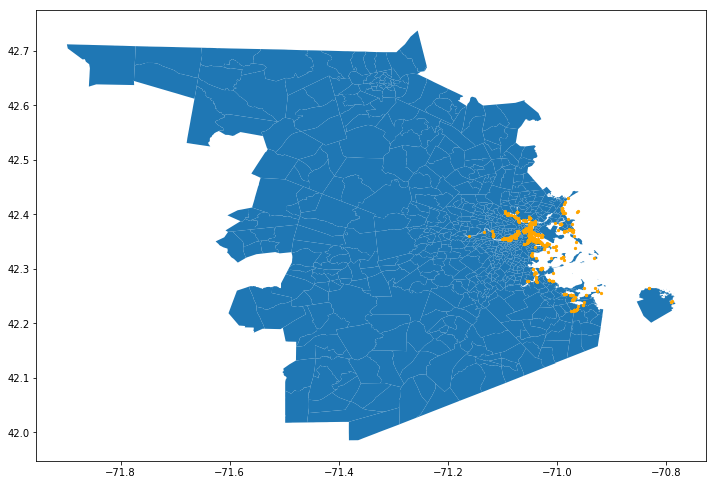

In [10]:
# Which points were not able to get assigned tracts?
# plot these lat,lon points that have no assigned tract on top of the tracts shapefile

null_areas_df = areas_df[areas_df.isnull().any(axis=1)]
print('%s/%s = %s points in dataset where unable to assign census tract' % (
    null_areas_df.shape[0], areas_df.shape[0], null_areas_df.shape[0]/areas_df.shape[0]))

tractless_points_geometry = [Point(xy) for xy in zip(null_areas_df["lon"], null_areas_df["lat"])]
# Plot them 
tractless_points_df = gpd.GeoDataFrame(null_areas_df,crs={'init': 'espg:4326'},geometry=tractless_points_geometry)
fix,ax = plt.subplots(figsize=(12,12))
tracts_shapefile.plot(ax=ax)
tractless_points_df.plot(ax=ax, markersize=5, color='orange')

Upon inspection, we see that there are datapoints that are in the water!
This is why they were not assigned census tracts. They are dropped.

In [11]:
areas_df = areas_df.dropna()

In [12]:
# Save the data
areas_df.to_csv(data_filepath, index=False)

## Attach blockgroup

Using the fact that blockgroup GEOID is prefixed by tract GEOID

reading shapefile ./shapefiles/ma/blockgroup_middlesex_norfolk_suffolk.shp


,STATEFP10,COUNTYFP10,TRACTCE10,BLKGRPCE10,GEOID10,NAMELSAD10,MTFCC10,ALAND10,AWATER10,INTPTLAT10,...,AREA_ACRES,POP100_RE,HU100_RE,LOGPL94171,LOGSF1,LOGACS0610,LOGSF1C,SHAPE_AREA,SHAPE_LEN,geometry
0,25,021,456402,2,250214564022,Block Group 2,G5030,5107660.0,104225.0,+42.0980485,...,1287.7929,1331,465,0142091,123983,0007625,0123983,5.211534e+06,9996.085232,POLYGON ((-71.09325358686991 42.09046962120169...
1,25,021,456402,1,250214564021,Block Group 1,G5030,4674851.0,343496.0,+42.0856597,...,1239.9721,981,312,0142090,123982,0007624,0123982,5.018009e+06,10171.313638,POLYGON ((-71.11289359194581 42.08290061881614...
2,25,021,456402,3,250214564023,Block Group 3,G5030,3420837.0,237352.0,+42.1168451,...,903.8929,2387,801,0142092,123984,0007626,0123984,3.657940e+06,8622.142376,POLYGON ((-71.11841459590471 42.12182462643546...


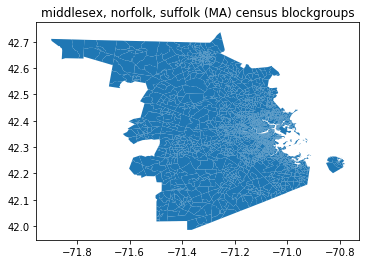

In [11]:
# Load in the shapefile
blockgroups_shapefile_filepath = get_shapefile_filepath('ma', 'blockgroup', counties)
print('reading shapefile', blockgroups_shapefile_filepath)

blockgroups_shapefile = gpd.read_file(blockgroups_shapefile_filepath).to_crs(epsg=4326)
blockgroups_shapefile.plot()
plt.title(', '.join(counties) + ' (MA) census blockgroups')

blockgroups_shapefile.head(3)

In [ ]:
print('getting and attaching blockgroup for %s lat,lon points' % areas_df.shape[0])

def get_blockgroup(data_row, shapefile=blockgroups_shapefile):
    if random.randint(1, 10000) == 10000:
        print(datetime.now(), ":1/10000: get_blockgroup")
    lat = float(data_row['lat'])
    lon = float(data_row['lon'])
    geoid_prefix = data_row[TRACT]
    point = Point(lon, lat) # the points actually reverse - yes this looks weird but consider lon the x-axis and lat the y-axis on an x-y plane...
    for i, shp_row in shapefile.iterrows():
        blockgroup_geoid = shp_row[GEOID]
        if not blockgroup_geoid.startswith(geoid_prefix):
            continue
        try:
            # this could be a Polygon or a Multipolygon when the tract contains islands (<3 New England)
            polygon = shp_row['geometry']
            if point.within(polygon):
                return blockgroup_geoid
        except Exception as e:
            print('Exception when looking for point in blockgroup ' + blockgroup_geoid, ': ', e)
            raise e
    print('No blockgroup found for data row!', data_row)
    return None

areas_df[BLOCKGROUP] = areas_df.apply(get_blockgroup, axis=1)

## Attach block

Using the fact that block GEOID is prefixed by tract GEOID (see https://www.census.gov/programs-surveys/geography/guidance/geo-identifiers.html)

In [ ]:
# Load in the shapefile
blocks_shapefile_filepath = get_shapefile_filepath('ma', 'block', counties)
print('reading shapefile', blocks_shapefile_filepath)

blocks_shapefile = gpd.read_file(blocks_shapefile_filepath).to_crs(epsg=4326)
blocks_shapefile.plot()
plt.title(', '.join(counties) + ' (MA) census blocks')

blocks_shapefile.head(3)

In [ ]:

def get_block(data_row, shapefile=blocks_shapefile):
    if random.randint(1, 10000) == 10000:
        print(datetime.now(), ":1/10000: get_block")
    lat = float(data_row['lat'])
    lon = float(data_row['lon'])
    geoid_prefix = data_row[TRACT] # NOT prefixed by the blockgroup
    point = Point(lon, lat) # the points actually reverse - yes this looks weird but consider lon the x-axis and lat the y-axis on an x-y plane...
    for i, shp_row in shapefile.iterrows():
        block_geoid = shp_row[GEOID]
        if not block_geoid.startswith(geoid_prefix):
            continue
        try:
            # this could be a Polygon or a Multipolygon when the tract contains islands (<3 New England)
            polygon = shp_row['geometry']
            if point.within(polygon):
                return block_geoid
        except Exception as e:
            print('Exception when looking for point in block ' + block_geoid, ': ', e)
            raise e
    print('No block found for data row!', data_row)
    return None

areas_df[BLOCK] = areas_df.apply(get_block, axis=1)

areas_df.head()